In [1]:
import sys
from pathlib import Path

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

# parameters
dataset_name = 'CIFAR10'
data_root = Path.cwd().parent / 'data'

## Model 1: Eight Layer Conv Net

#### Architecture Overview

My EightLayerConvNet's backbone is somewhat inspired by VGG16 (16 layers), alternating convolutional layers with a kernel size of 3 and max pooling layers at the end of each block except for the last one. However, since we're working with CIFAR-10's 32x32 images rather than ImageNet's 224x224 images, most other architectural aspects differ significantly from the original VGG design.

EightLayerConvNet has three convolutional blocks where each block contains only two convolutional layers, with the number of filters doubling after each block. We use AdaptiveAvgPool2d for global pooling in the final convolutional layer, followed by a fully connected layer with 512 neurons, a dropout layer, and a final linear output layer with 10 neurons. This architecture prioritizes efficient feature extraction while maintaining simplicity i.e. just enough layers to get the job done.

I use BatchNorm2d with a momentum of 0.6 and ReLU activation functions with inplace=True. BatchNorm2d helps stabilize training and prevent overfitting. Since there's BatchNorm2d, we can omit the bias terms in our convolutional layers—I'll explain why in the technical details further below.

The convolutions use padding='same'. Our classifier consists of two fully connected layers: the first with 512 neurons (with bias) and the second with 10 neurons (without bias, since we're using cross-entropy loss with softmax). Lastly, weights are initialized using orthogonal initialization with gain=1.

For training, I use:
- Batch size: 1024
- Initial learning rate: 0.1
- SGD optimizer with momentum: 0.9
- Weight decay: 0.01
- MultiStepLR scheduler (milestones: [8, 13], gamma: 0.1)
- Data augmentation: random cropping and horizontal flipping (inspired by various CIFAR-10 implementations, notably [pytorch-cifar](https://github.com/kuangliu/pytorch-cifar))

Let's dive into some of the technical details that weren't covered in our course:


#### Technical Deep Dive

**BatchNorm2d - What and Why?**  
BatchNorm was introduced in 2015 by Ioffe and Szegedy in their paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167). The idea is brilliantly simple: normalize the data not just at input but at each layer. This helps solve the "internal covariate shift" problem, where the distribution of each layer's inputs keeps changing during training.

When using BatchNorm2d, we can set the bias parameter to false in convolutional layers. This is because BatchNorm2d's learnable parameters β and γ already handle the bias functionality, making the convolution layer's bias redundant. This optimization reduces computations without affecting model performance.

**BatchNorm's Momentum - The Running Average**  
According to [PyTorch's BatchNorm2d documentation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), the momentum parameter (0.6 in our case) is used differently than in optimizers. For running statistics, the update rule is:

x_new = (1 - momentum) * x + momentum * x_t

where x is our estimated statistic (mean or variance) and x_t is the new observed value. With momentum = 0.6, each update keeps 40% of the previous estimate and incorporates 60% of the new batch statistics. This helps maintain stable statistics while adapting to changes in the data distribution.

**ReLU's inplace=True - Memory Efficiency**  
The inplace parameter in ReLU is a memory optimization. When True, ReLU modifies its input tensor directly instead of creating a new one, saving memory during training.


**AdaptiveAvgPool2d((1, 1)) - Global Feature Aggregation**  
The AdaptiveAvgPool2d((1, 1)) layer performs global average pooling, reducing spatial dimensions to 1×1 while preserving the channel dimension. Each channel creates a summary of its spatial information into a single value - instead of having 64 values (8×8) per channel, we get their average as a global summary. This technique was popularized by the [Network In Network paper (Lin et al., 2013)](https://arxiv.org/abs/1312.4400) as a more parameter-efficient alternative to using multiple fully connected layers. It helps reduce overfitting and makes the network more robust to spatial translations, meaning the model becomes less sensitive to the exact position of objects within the image.

**SGD with Momentum - Accelerated Optimization**  
[Momentum](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d) in SGD helps accelerate optimization by accumulating a running average of past gradients. 

Without momentum, the weight update is new_weight = old_weight - learning_rate * gradient.

With momentum we have something called a velocity term. The update rule is then new_weight = old_weight - velocity, where velocity is:

new_velocity = momentum * old_velocity + learning_rate * gradient.

The momentum helps in two ways: it smooths out noisy gradient estimates from small batches, and it helps navigate narrow valleys in the loss landscape where standard SGD might oscillate between the sides.

**Weight Initialization - Orthogonal Initialization**  
We initialize the convolutional and linear layer weights using orthogonal initialization with gain=1. This technique, studied in [Saxe et al. (2013)](https://arxiv.org/abs/1312.6120), creates weight matrices whose columns are orthogonal to each other. Orthogonal matrices preserve input magnitudes during forward propagation, helping prevent vanishing gradients in deep networks. The bias of the first fully connected layer is initialized to zero, allowing the network to learn appropriate shifts based purely on the data distribution. We omit the bias in the final layer because we're using cross-entropy loss with softmax, where bias terms would be redundant since softmax is translation-invariant (shifting all logits by a constant doesn't change the probabilities).

**Augmentation - Cropping and Flipping**  
The augmentation techniques we use include random cropping and horizontal flipping. These are common methods for data augmentation and are fundamental concepts demonstrated in PyTorch's documentation under the section titled ["I just want to do image classification"](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py). This augmentation is particularly prevalent for CIFAR-10 and has been empirically shown to enhance performance. Random cropping allows the model to learn object recognition across different spatial contexts, while horizontal flipping enables the model to generalize across symmetrical orientations.

#### Model Performance and Next Steps
My process for building this model was iterative, taking one step at a time and adding one thing at a time, getting slightly better each time. The model was, in its final state, able to periodically reach around 87-88% accuracy on the validation set, but sometimes struggled to reach 84%. It was quite unstable, with early stopping getting triggered quite often before it reached the set amount of epochs.

Early stopping wasn't just set because of impatience (okay, maybe a little bit), but mainly because I noticed a clear pattern - if the model showed no improvement for 2-5 epochs, it wouldn't improve even after 100 epochs. It would just get stuck in a bad local minimum. I verified this through multiple longer training runs, so the early stopping actually saved a lot of computation time.

I started to mess with the learning rates and noticed in the loss curves that, besides the hockey stick in the beginning, there were some early issues - a "bump" that the model needed to get over around epoch 5-8. I lowered the learning rate there, and then noticed another bump around epoch 13. Lowering it there also made it possible for the model to continue training to around epoch 20 before things got boring...most of the time.

At this point, the model could reach about 85% accuracy, but it varied from session to session: sometimes early stopping was triggered before 85%, sometimes it took 40 epochs to reach say 87%. My goal now was clear: reach 90%+ accuracy, reliably in 20 epochs or less.

After the process of tinkering with the learning rate, I started to notice some patterns in the model's performance that indicated I should be able to tune it in a more sophisticated way than just reducing the learning rate at certain epochs. This brings us to our next model, which, thanks to a resource I found, gave me the idea to use a "triangle" learning rate scheduler. This solved exactly that problem. Instead of analyzing this model further, let's move on to our main, and in my eyes, best performing model when it comes to both training speed and accuracy.

Files already downloaded and verified
Files already downloaded and verified
Using FP16 (half precision) training
[epoch 01] train loss: 1.6388 | val loss: 1.5740 | accuracy: 39.46%
Validation loss decreased (inf --> 1.5740). Saving model.
[epoch 02] train loss: 1.1944 | val loss: 1.2455 | accuracy: 54.92%
Validation loss decreased (1.5740 --> 1.2455). Saving model.
[epoch 03] train loss: 1.0078 | val loss: 1.1156 | accuracy: 61.14%
Validation loss decreased (1.2455 --> 1.1156). Saving model.
[epoch 04] train loss: 0.8946 | val loss: 0.9456 | accuracy: 67.49%
Validation loss decreased (1.1156 --> 0.9456). Saving model.
[epoch 05] train loss: 0.6894 | val loss: 0.6450 | accuracy: 78.51%
Validation loss decreased (0.9456 --> 0.6450). Saving model.
[epoch 06] train loss: 0.6094 | val loss: 0.6131 | accuracy: 79.19%
Validation loss decreased (0.6450 --> 0.6131). Saving model.
[epoch 07] train loss: 0.5686 | val loss: 0.5835 | accuracy: 80.12%
Validation loss decreased (0.6131 --> 0.5835). S

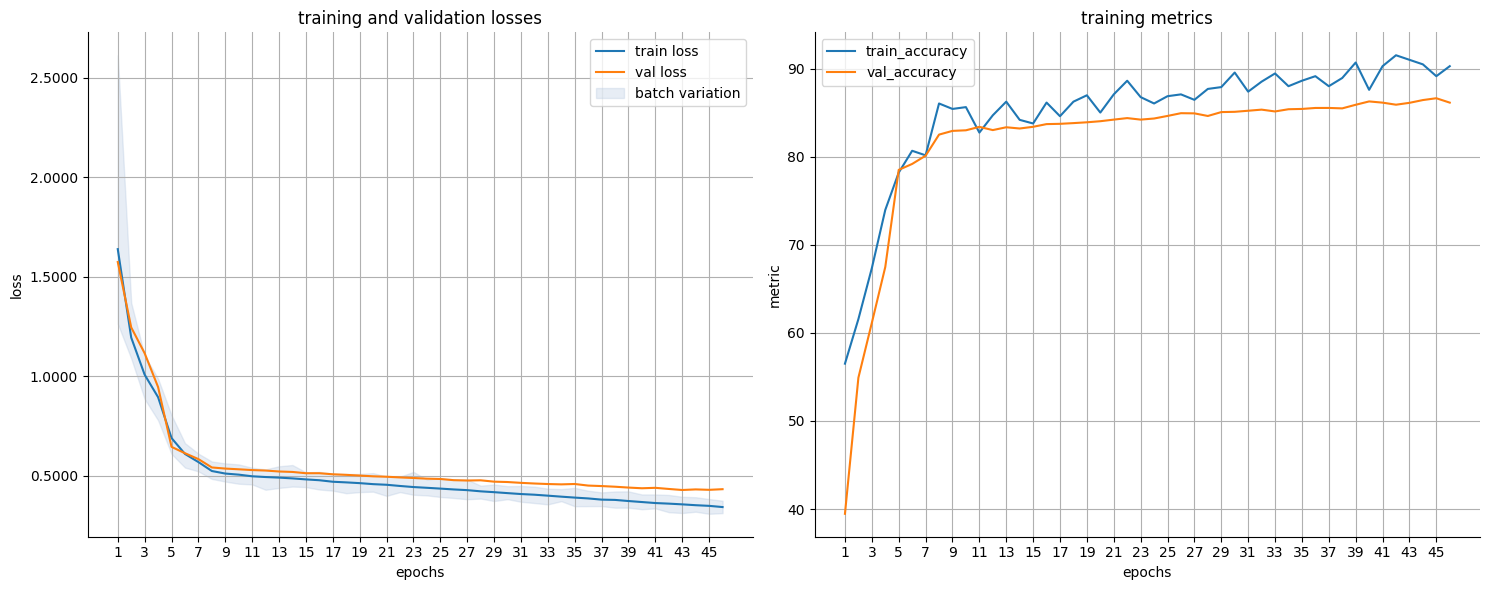

In [14]:
from src import prepare_datasets, ModelTrainer, accuracy
from models.eight_layer_conv_net.architecture import EightLayerConvNet
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

trainset, valset, testset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_val=transform_val,
    normalize=False,
    use_validation_split=True,
)

def train_model(model, model_name, num_epochs=200):
    optimizer = SGD(
        model.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=0.01,
    )
    
    scheduler = MultiStepLR(
        optimizer,
        milestones=[8, 13],
        gamma=0.1
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=1024,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=3,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model1 = EightLayerConvNet()
trainer1 = train_model(model1, "EightLayerConvNet", num_epochs=100)

In [12]:
test_results_1 = trainer1.evaluate_on_test(test_set=testset)


Loading Best Model for Test Evaluation
Test Loss: 0.4491 | accuracy: 85.77


#### Class Accuracies

This section displays the class accuracies as a reference point for the upcoming model, where we will conduct a more thorough error analysis. Without revealing too much, the errors of the next models are quite similar to those of this one – just significantly improved.

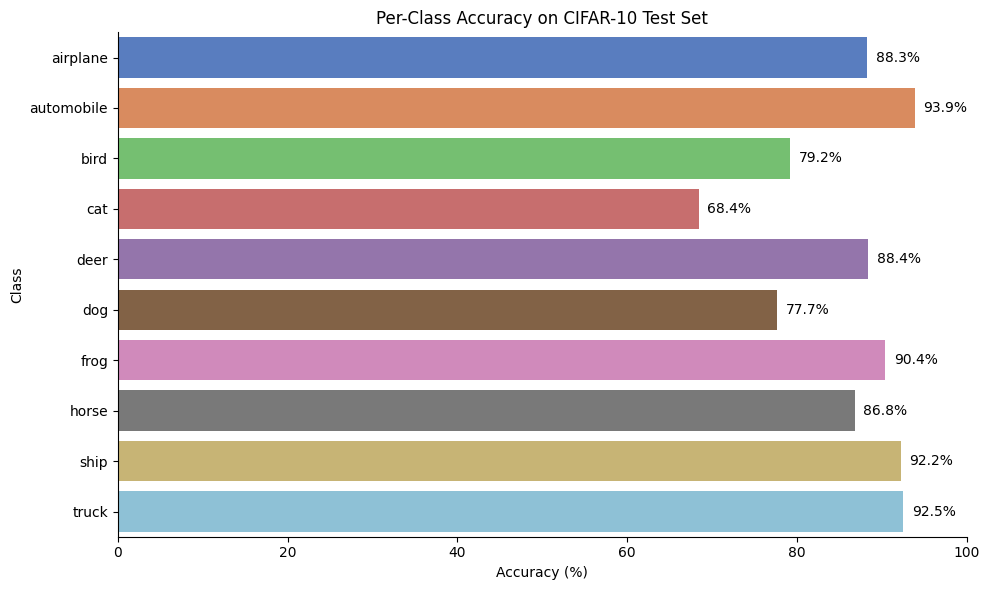

In [13]:
from src import MetricsPlotter
import numpy as np

predictions = test_results_1['predictions']
true_labels = test_results_1['true_labels']

def calculate_per_class_accuracy(true_labels, predictions, num_classes=10):
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)
    
    for i in range(len(true_labels)):
        label = true_labels[i]
        class_total[label] += 1
        if predictions[i] == label:
            class_correct[label] += 1

    per_class_accuracy = (class_correct / class_total) * 100
    return per_class_accuracy

per_class_accuracy = calculate_per_class_accuracy(true_labels, predictions)

# plot
plotter = MetricsPlotter()
ax = plotter.plot_class_accuracy(per_class_accuracy, testset.classes, dataset_name="CIFAR-10")

## Model 2: Eight Layer Conv Net Modified

### Model Overview

Here we are with my model of choice. Using an ancient RTX 2070 SUPER from 2019, we can consistently achieve a model with 91% accuracy in just 1.5 minutes by training it for less than 20 epochs. This model is very similar to the previous one, but it includes a few, albeit very important, modifications.

Looking at the loss curves, we can see that our improved model doesn't have the same "hockey stick" shape as the previous model. This is because the learning rate scheduler is changed to a OneCycleLR scheduler. This scheduler is a more sophisticated learning rate scheduler that is able to take us from 84% accuracy to 91% accuracy in the same 20 epochs. Without going into too much detail, it basically means that instead of the learning rate just being reduced at certain epochs, it instead works like a triangle - starting at a low learning rate (called warmup, this addresses the hockey stick effect and stabilizes early training), increasing to a high learning rate, and then decreasing back to a low learning rate. This is inspired by [Keller Jordan](https://arxiv.org/pdf/2404.00498) which in turn is inspired by [tysam-code](https://github.com/tysam-code/hlb-CIFAR10). To learn more about this scheduler, read the inline comments in the code below and check out pytorch's [documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html).


While the learning rate was the most pivotal change, there were also a few other modifications:

- Enhanced the orthogonal weight initialization by changing the gain factor from 1 to $\sqrt{2}$ and noticed a small improvement in performance and convergence speed.
- Padding mode for RandomCrop was changed to reflect, training got more stable.
- step_scheduler_batch=True was added to the ModelTrainer. This allows the learning rate scheduler to be updated after each batch instead of after each epoch. This was a prerequisite for the OneCycleLR scheduler to work (see the [documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html)).

Model performance and error analysis is found in the next section.

Files already downloaded and verified
Files already downloaded and verified
Using FP16 (half precision) training
[epoch 01] train loss: 1.6533 | val loss: 1.3672 | accuracy: 48.17%
Validation loss decreased (inf --> 1.3672). Saving model.
[epoch 02] train loss: 1.1904 | val loss: 1.2322 | accuracy: 55.04%
Validation loss decreased (1.3672 --> 1.2322). Saving model.
[epoch 03] train loss: 0.9993 | val loss: 1.1049 | accuracy: 61.74%
Validation loss decreased (1.2322 --> 1.1049). Saving model.
[epoch 04] train loss: 0.8625 | val loss: 1.1574 | accuracy: 58.62%
EarlyStopping counter: 1 out of inf
[epoch 05] train loss: 0.8015 | val loss: 0.8714 | accuracy: 69.13%
Validation loss decreased (1.1049 --> 0.8714). Saving model.
[epoch 06] train loss: 0.7262 | val loss: 1.0803 | accuracy: 63.39%
EarlyStopping counter: 1 out of inf
[epoch 07] train loss: 0.6362 | val loss: 0.7259 | accuracy: 75.81%
Validation loss decreased (0.8714 --> 0.7259). Saving model.
[epoch 08] train loss: 0.6315 | val l

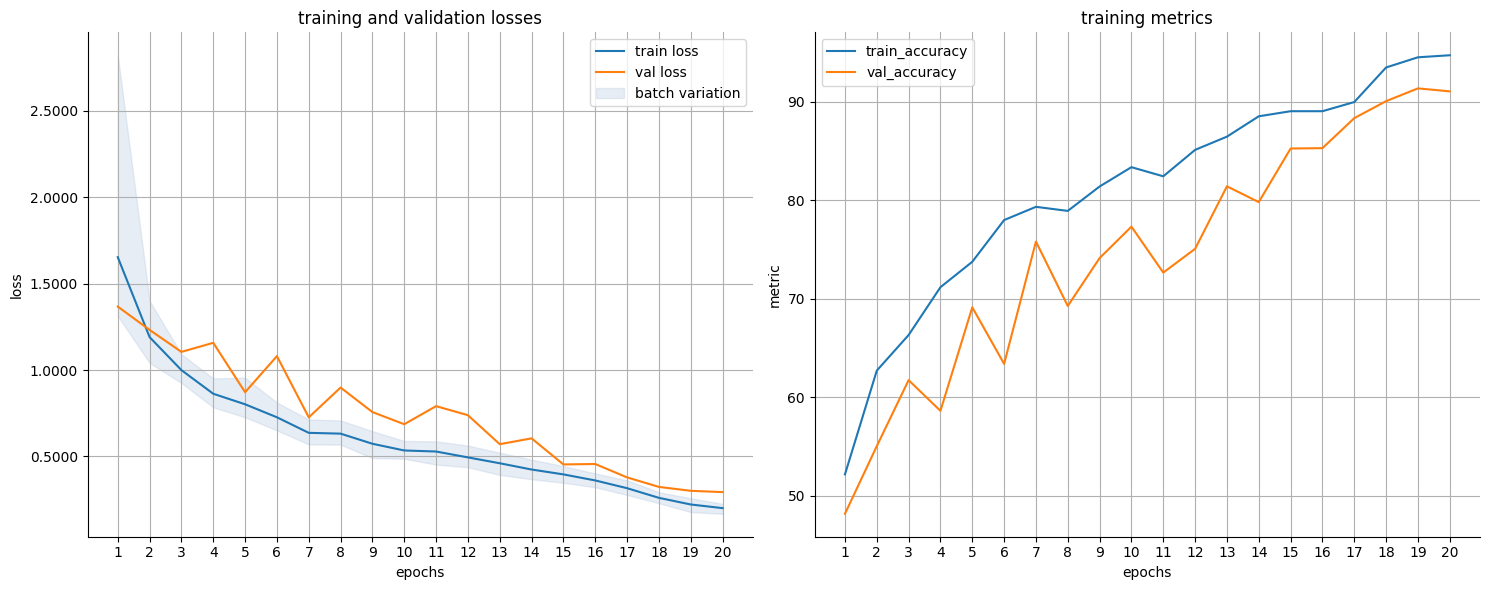

In [6]:
from src import prepare_datasets, ModelTrainer, accuracy
from models.eight_layer_conv_net.architecture import EightLayerConvNet
import torch
import torch.nn as nn
from torch.optim import SGD
from torchvision import transforms

from models.mod_eight_layer_conv_net.architecture import ModEightLayerConvNet
from torch.optim.lr_scheduler import OneCycleLR
import math

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

trainset, valset, testset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_val=transform_val,
    normalize=False,
    use_validation_split=True
)

def train_model(model, model_name, num_epochs=200):

    max_lr = 0.1
    div_factor = 5          # controls initial LR: higher = lower start (max_lr/div_factor = 0.1/5 = 0.02)
    final_div_factor = 15   # controls decay speed: higher = faster decay (max_lr/final_div_factor = 0.1/15 ≈ 0.007)
    initial_lr = max_lr / div_factor
    
    # adjust warmup length based on absolute epochs, not percentage
    # absolute_warmup_epochs = 12
    # pct_start = absolute_warmup_epochs / num_epochs  # dynamically calculated
    pct_start = 0.23
   
    optimizer = SGD(
        model.parameters(),
        lr=initial_lr,
        momentum=0.9,
        weight_decay=0.01,
    )

    # calculate total steps
    steps_per_epoch = math.ceil(len(trainset) / 1024)
    total_steps = steps_per_epoch * num_epochs

    scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,                     # (1) Peak learning rate
        total_steps=total_steps,           # (2) Total number of training iterations
        pct_start=pct_start,               # (3) Percentage of training spent in warmup
        div_factor=div_factor,             # (4) Initial LR division factor  (Initial LR = max_lr/div_factor = 0.1/5 = 0.02)
        final_div_factor=final_div_factor, # (5) Final LR division factor    (Final LR = max_lr/final_div_factor = 0.1/15 ≈ 0.007)
        anneal_strategy='cos'              # (6) Type of annealing (default 'cos')
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=1024,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=float('inf'),
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        step_scheduler_batch=True,

    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model2 = ModEightLayerConvNet()
trainer2 = train_model(model2, "ModEightLayerConvNet", num_epochs=20)

In [3]:
test_results_2 = trainer2.evaluate_on_test(test_set=testset)


Loading Best Model for Test Evaluation


Test Loss: 0.2976 | accuracy: 91.02


### Model Performance Insights
#### Class Accuracies

Our analysis shows that cats, birds, and dogs have the lowest accuracy rates among all classes. Cats perform the worst with around 83% accuracy rate, while most other classes (excluding these three) achieve accuracies above 93%.

To better understand our model's weakness with cats, we need to investigate what the model is confusing them with. This leads us to our next question: What specific patterns are causing the model to struggle with cat classification?

To answer this, we need to examine the confusion matrix, which will provide more granular metrics. Several scenarios could explain this performance:
1. The model might be producing false positives (e.g., incorrectly classifying dogs as cats)
2. The model might be generating false negatives (e.g., missing actual cats and classifying them as other classes)

Since accuracy alone cannot reveal these patterns, our next step is to analyze the confusion matrix for a detailed view of these misclassifications.

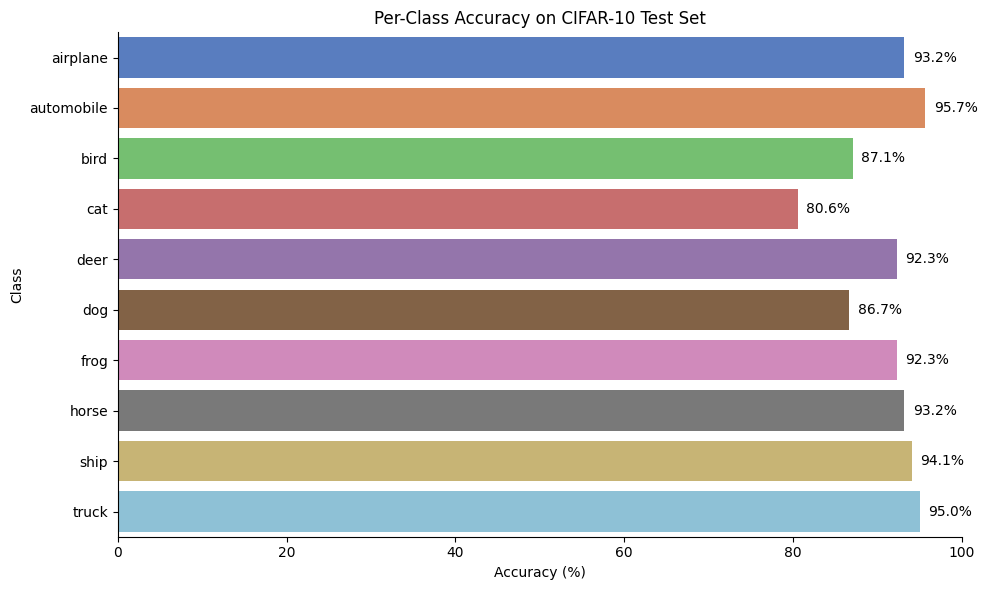

In [5]:
from src import MetricsPlotter
import numpy as np

predictions = test_results_2['predictions']
true_labels = test_results_2['true_labels']

per_class_accuracy = calculate_per_class_accuracy(true_labels, predictions)

# plot
plotter = MetricsPlotter()
ax = plotter.plot_class_accuracy(per_class_accuracy, testset.classes, dataset_name="CIFAR-10")

#### Confusion Matrix

The classification errors between cats and dogs appear to be bidirectional. The model frequently confuses cats with dogs and vice versa. 

As for birds, our third problematic class, the confusion is more distributed across various classes, though notably not with automobiles or trucks. 

While there are other patterns to explore, the cat/dog confusion stands out as the most significant issue. Given more time, we could investigate this further by implementing specialized data augmentations or more sophisticated convolution patterns to help the model better distinguish between these two classes. 

However, before considering such improvements, we need to deepen our understanding of the problem. Our next step is to examine the actual misclassified images to identify visual patterns that might explain the model's confusion. This analysis is crucial not only for understanding the current limitations but also for developing targeted solutions to improve the model's performance.

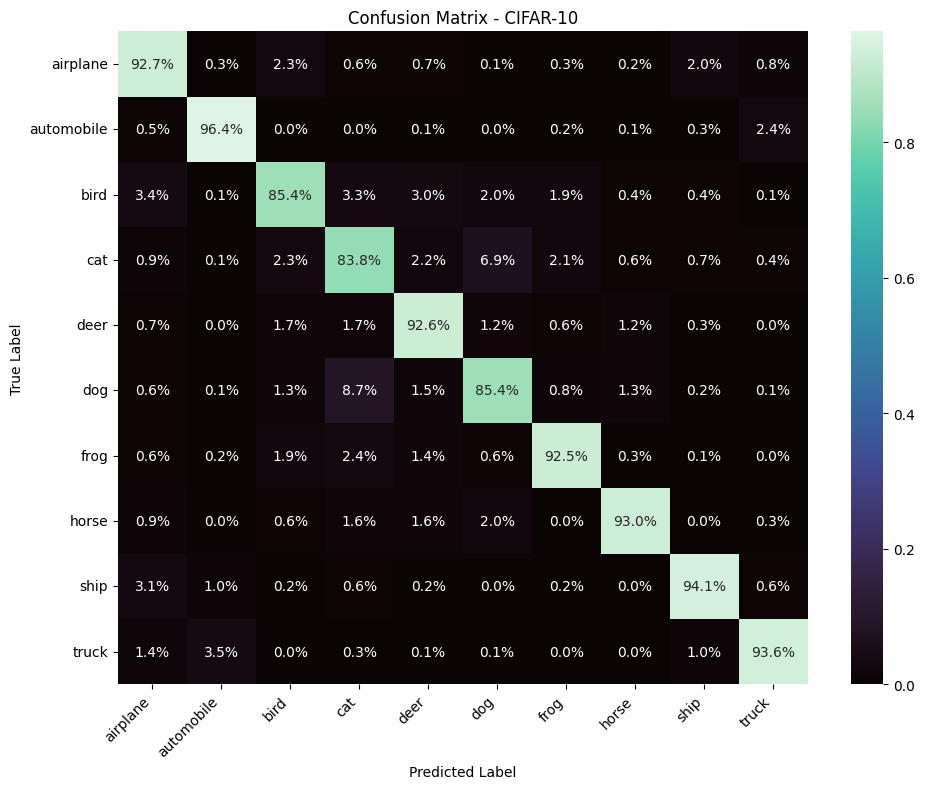

In [24]:
from matplotlib import pyplot as plt

# plot normalized confusion matrix
plotter.plot_confusion_matrix(
    predictions=predictions,
    true_labels=true_labels,
    class_names=testset.classes,
    dataset_name="CIFAR-10",
    normalize=True,
    cmap='mako'
)

plt.tight_layout()

#### Classification Examples: Cats vs Dogs

Looking at these comparison images, we can see interesting patterns in how our model handles cats and dogs. We've arranged the examples to show both misclassifications and correct predictions, and each time we run this code, we get new random examples to analyze.

The confusion between cats and dogs makes sense when you look closely. Dogs with prominent, pointed ears often get mistaken for cats, and when cats take certain poses that are typically "dog-like," the model gets confused. This isn't too surprising since they share many physical characteristics - both are four-legged animals that can look quite similar in certain poses.

What's interesting is that when the model makes mistakes, it's often not very confident in its prediction. We see quite a few cases where the confidence is below 50%, which actually gives us hope - the model isn't confidently wrong, it's unsure. The main takeaways from looking through these examples are:
- Pointy-eared dogs often trigger cat predictions
- Cats in certain poses (especially with heads down) get classified as dogs
- When image quality is poor, mistakes are more common, but that's not really the model's fault

These insights could be valuable for future improvements to the model.

As a side note, our third "bonus model" (which uses transfer learning with EfficientNet-B4) shows some interesting improvements in this area. It handles the dog-to-cat confusion much better - when it sees a dog, it much less often mistakes it for a cat. However, it's fascinating that even this more sophisticated model still struggles with cats, occasionally misclassifying them as dogs. This persistent cat-to-dog confusion suggests there might be something fundamentally challenging about certain cat features that even advanced architectures find tricky to handle.


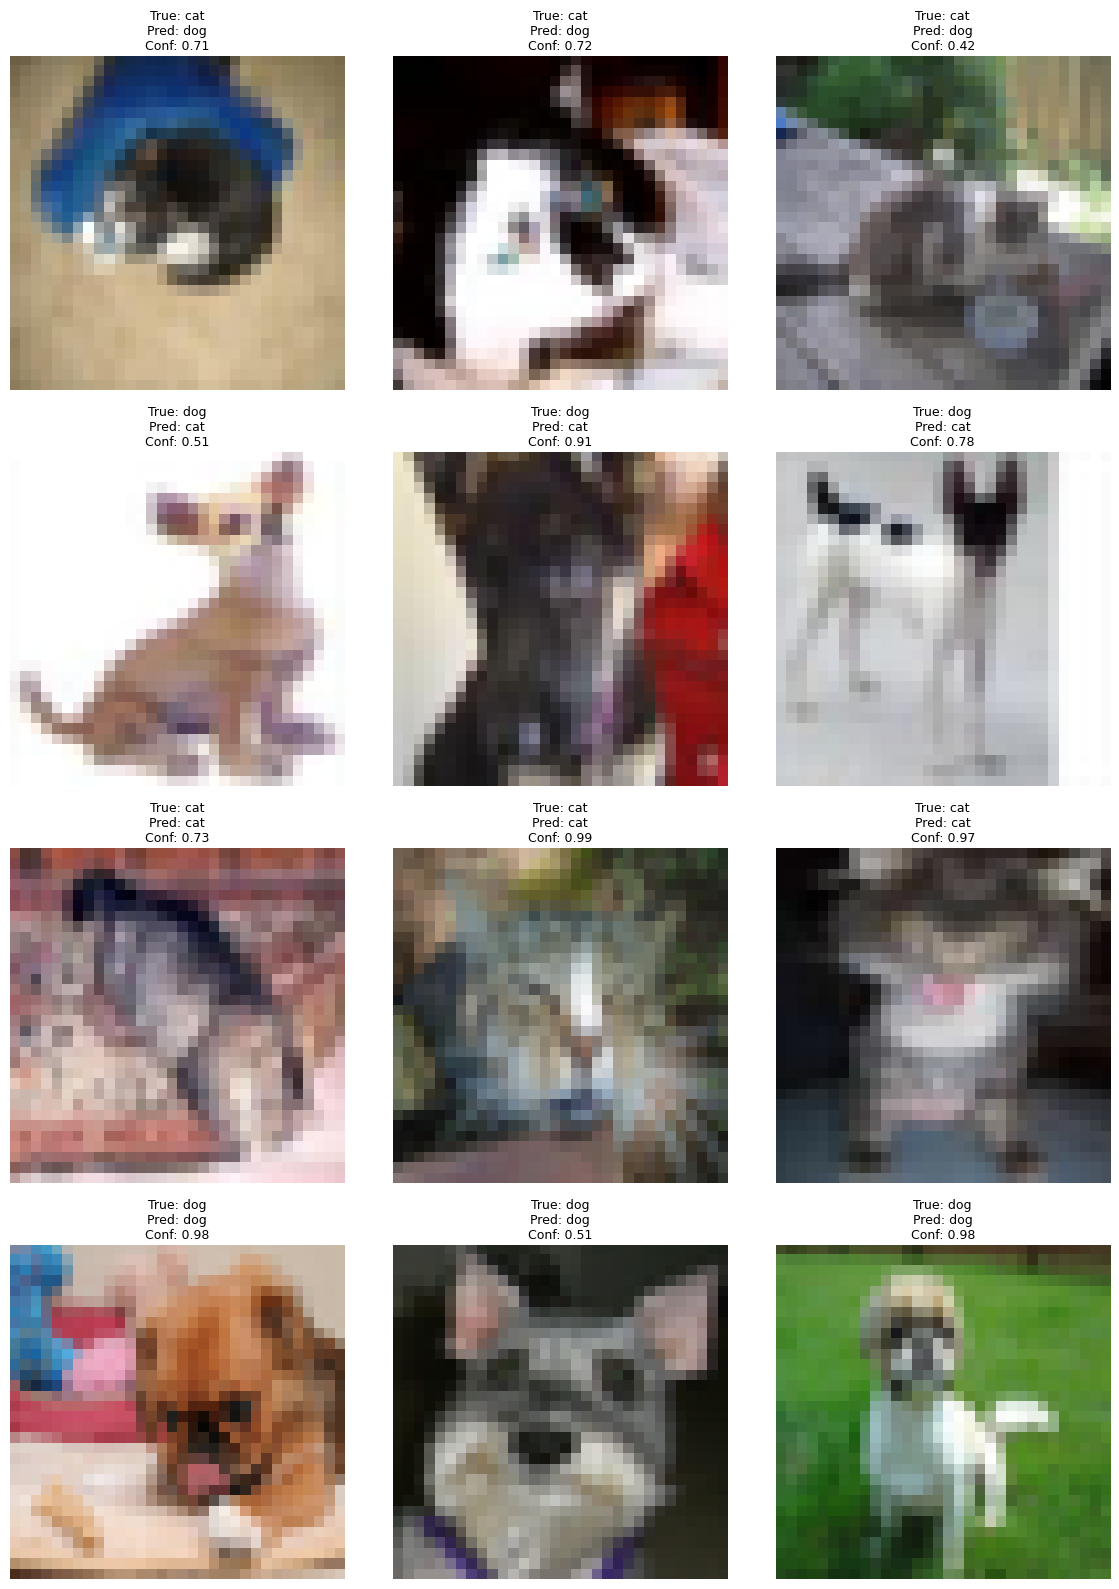

In [15]:
probabilities = test_results_2['probabilities']

# get images from test loader
images = []
for img, _ in test_results_2['test_loader']:
    images.extend(img.numpy())
images = np.array(images)

# create plotter
plotter = MetricsPlotter()

# Example 1: Look at cat-dog confusion
scenarios = [
    {'true': 'cat', 'pred': 'dog', 'n': 3},  # cats predicted as dogs
    {'true': 'dog', 'pred': 'cat', 'n': 3},  # dogs predicted as cats
    {'true': 'cat', 'pred': 'cat', 'n': 3},  # correctly classified cats
    {'true': 'dog', 'pred': 'dog', 'n': 3},  # correctly classified dogs
]

fig = plotter.plot_classification_examples(
    predictions=predictions,
    true_labels=true_labels,
    probabilities=probabilities,
    images=images,
    class_names=testset.classes,
    scenarios=scenarios
)

# fig.savefig('assets/classification_examples_cats_dogs.png')

### Bonus Model: Transfer Learning EfficientNet-B4

The choice of EfficientNet-B4 was initially inspired by [Josef Rynkiewicz's implementation](https://github.com/JosephRynkiewicz/CIFAR10), but it makes sense for our use case. B4 sits in the middle of the [EfficientNet](https://arxiv.org/pdf/1905.11946) family (B0-B7), providing a good balance between model capacity and computational requirements.

We're using feature extraction from the last layer, which is suitable considering:
- CIFAR-10 (50,000 images) is relatively small compared to ImageNet (1.2M images).
- Both datasets handle similar object recognition tasks.
- Pre-trained ImageNet features should transfer well to CIFAR-10.

Here are some specifics:
- Augmentation includes random cropping with a slightly smaller scale than evaluation. This reduces the computational load during training while still allowing for detailed evaluation.
- Otherwise, we are using standard CIFAR-10 optimizer settings: a learning rate of 0.01 and momentum of 0.9; however, we apply a smaller weight decay since overfitting is less of a problem.
- The scheduler is straightforward, with a step size of 10 and a gamma of 0.1.

Besides these specifics, we're simply hitting the ground running with the pre-trained EfficientNet-B4 model, extracting features from CIFAR-10 and fine-tuning the output layer.

#### Reflection on EfficientNet Implementation

I didn't create EfficientNet and can't take credit for it; that is, I won't consider it "my best performing model." However, it was a great learning experience to implement it. I was definitely surprised that just importing this model from PyTorch and fine-tuning the output layer worked so well—outperforming pretty much any architecture I was able to build.

What's even more baffling to me is that there are geniuses out there who can create models that achieve up to 94% accuracy, but still just train them solely on CIFAR-10 for only 3 seconds on a single GPU, or reach 96% accuracy after training for 27 seconds. I did spend some time trying to emulate some of these models, but it was just too much work for too little gain. (What is considered "little" and what is "much" is relative; a 2% increase can be significant. I also read that 94% is what is required to be considered as beating human performance.)

I'm quite happy reaching around 92% accuracy on my own model, and it felt satisfying to be able to "cheat" like this and bump it up to approximately 98% accuracy.

Files already downloaded and verified
Files already downloaded and verified
Loaded pretrained weights for efficientnet-b4
Using FP16 (half precision) training
[epoch 01] train loss: 0.4261 | val loss: 0.1279 | accuracy: 95.70%
Validation loss decreased (inf --> 0.1279). Saving model.
[epoch 02] train loss: 0.1817 | val loss: 0.1087 | accuracy: 96.38%
Validation loss decreased (0.1279 --> 0.1087). Saving model.
[epoch 03] train loss: 0.1309 | val loss: 0.0790 | accuracy: 97.19%
Validation loss decreased (0.1087 --> 0.0790). Saving model.
[epoch 04] train loss: 0.0956 | val loss: 0.0820 | accuracy: 97.33%
EarlyStopping counter: 1 out of 50
[epoch 05] train loss: 0.0788 | val loss: 0.0755 | accuracy: 97.63%
Validation loss decreased (0.0790 --> 0.0755). Saving model.
[epoch 06] train loss: 0.0594 | val loss: 0.0648 | accuracy: 97.81%
Validation loss decreased (0.0755 --> 0.0648). Saving model.
[epoch 07] train loss: 0.0527 | val loss: 0.0623 | accuracy: 97.93%
Validation loss decreased (0

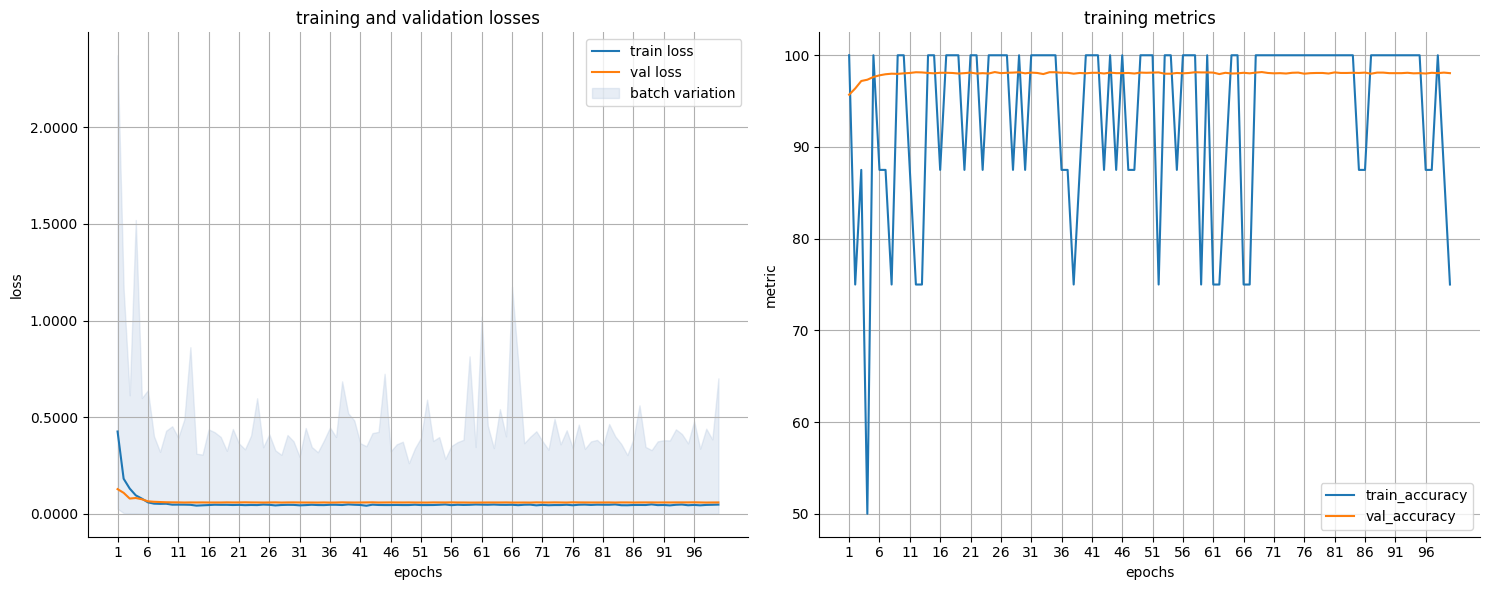

In [3]:
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import StepLR

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=160, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_val = transforms.Compose([
    transforms.Resize(200),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset, valset, testset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_val=transform_val,
    normalize=False,
    use_validation_split=True,
)

model3 = EfficientNet.from_pretrained('efficientnet-b4', num_classes=10)

optimizer = SGD(
    model3.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-6
)

scheduler = StepLR(
    optimizer,
    step_size=10,
    gamma=0.1
)

trainer3 = ModelTrainer(
    model=model3,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=32,
    verbose=True,
    save_metrics=True,
    early_stopping_patience=50,
    metrics=[accuracy],
    log_dir="logs/EfficientNet",
    logger_type="file"
)

trained_model3 = trainer3.train(
    training_set=trainset,
    val_set=valset,
    num_epochs=100
)

In [4]:
test_results_efficientnet = trainer3.evaluate_on_test(test_set=testset)

Loading Best Model for Test Evaluation
Test Loss: 0.0740 | accuracy: 97.70


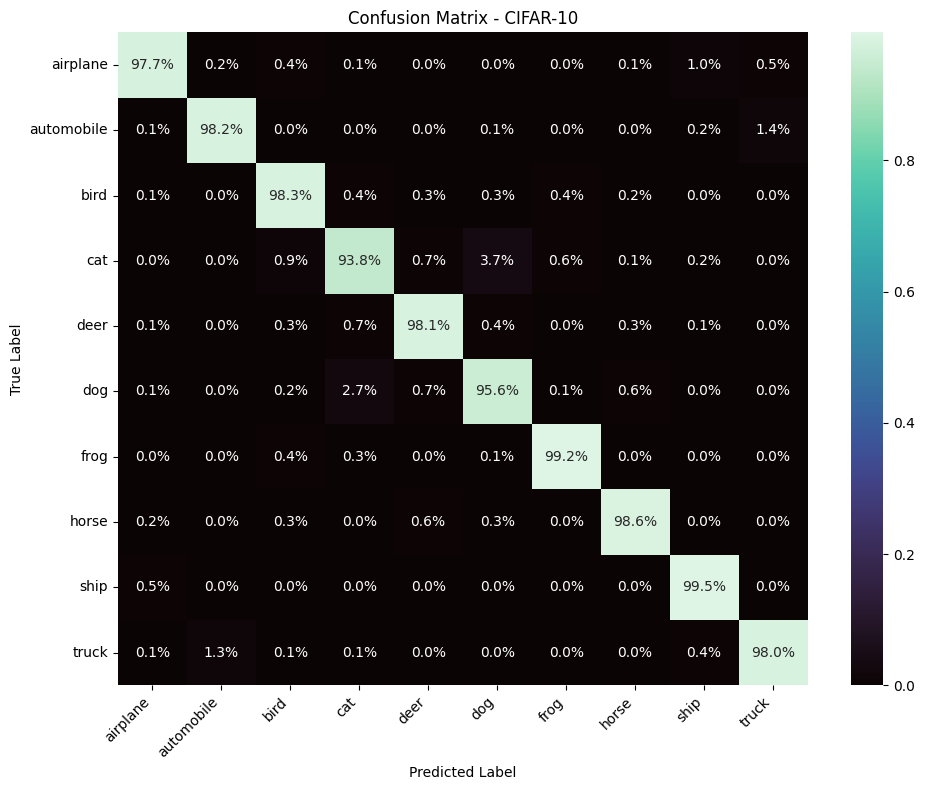

In [8]:
from src import MetricsPlotter

plotter = MetricsPlotter()
predictions_efficientnet = test_results_efficientnet['predictions']
true_labels_efficientnet = test_results_efficientnet['true_labels']

ax = plotter.plot_confusion_matrix(
    predictions=predictions_efficientnet,
    true_labels=true_labels_efficientnet,
    class_names=testset.classes,
    dataset_name="CIFAR-10",
    normalize=True,
    cmap='mako'
)